# references
- text classification with word embeddings https://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
- preparing reuters https://miguelmalvarez.com/2015/03/20/classifying-reuters-21578-collection-with-python-representing-the-data/
- classifying reuters with SVM https://miguelmalvarez.com/2016/11/07/classifying-reuters-21578-collection-with-python/
- MUSE for multilingual word embeddings https://github.com/facebookresearch/MUSE
- working with pretrained word vectors https://blog.manash.me/how-to-use-pre-trained-word-vectors-from-facebooks-fasttext-a71e6d55f27
- term frequency-inverse document frequency (word weighting heuristic) https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [1]:
import keras
import numpy as np
import os
import pickle

/media/Data/Ian/miniconda/envs/tf2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Get data from nltk

In [2]:
import nltk
from nltk.corpus import reuters
#nltk.download()

### get word embeddings

In [3]:
import os
import urllib
if not os.path.exists('wiki.multi.en.vec'):
    urllib.urlretrieve ("https://s3.amazonaws.com/arrival/embeddings/wiki.multi.en.vec", "wiki.multi.en.vec")

In [4]:
from gensim.models import KeyedVectors
embedding = KeyedVectors.load_word2vec_format('wiki.multi.en.vec')

In [5]:
## load
docs_dict = pickle.load(open(os.path.join('workingdir', 'cache.pkl'),'rb'))

### get inputs


In [6]:
from helper_functions import tf_idf, feature_values, tokenize
from keras.preprocessing.sequence import pad_sequences
from functools import partial

In [7]:
vocab_tokenizer = partial(tokenize, vocab=embedding.vocab)

In [8]:
# split data and train tf_IDF
train_docs = []
test_docs = []
train_doc_ids = []
test_doc_ids = []
for doc in reuters.fileids():
    if doc.startswith("train"):
        train_doc_ids.append(doc)
        train_docs.append(reuters.raw(doc))
    else:
        test_doc_ids.append(doc)
        test_docs.append(reuters.raw(doc))
if 'representer' not in docs_dict.keys():
    representer = tf_idf(train_docs, tokenize=vocab_tokenizer)
else:
    representer = docs_dict['representer']

In [9]:
# set max length to the 99th percentile length of all documents
MAX_SEQ_LEN = int(np.percentile([len(i) for i in train_docs+test_docs], 90))

In [10]:
# convert train docs to input
# tokenize
if 'train_docs_pad' not in docs_dict.keys():
    tokenized_inputs = [tokenize(doc, vocab=embedding.wv.vocab) for doc in train_docs]
    # convert to indices and pad
    def convert_to_index(doc, embedding):
        return [embedding.index2word.index(w) for w in doc]
    seqs = [convert_to_index(doc, embedding) for doc in tokenized_inputs]
    train_docs_pad = pad_sequences(seqs, maxlen=MAX_SEQ_LEN)
else:
    train_docs_pad = docs_dict['train_docs_pad']

In [11]:
# convert test docs to input
# tokenize
if 'test_docs_pad' not in docs_dict.keys():
    tokenized_inputs = [tokenize(doc, vocab=embedding.wv.vocab) for doc in test_docs]
    # convert to indices and pad
    def convert_to_index(doc, embedding):
        return [embedding.index2word.index(w) for w in doc]
    seqs = [convert_to_index(doc, embedding) for doc in tokenized_inputs]
    test_docs_pad = pad_sequences(seqs, maxlen=MAX_SEQ_LEN)
else:
    test_docs_pad = docs_dict['test_docs_pad']

In [12]:
def get_embedding(doc, representer, weighted=True):
    tfidf_rep = representer.transform([doc])
    if np.sum(tfidf_rep) == 0:
        doc_embedding = np.zeros(embedding.vector_size)
    else:
        tfidf_words = representer.inverse_transform(tfidf_rep)[0]
        weights = tfidf_rep.data
        doc_word_embedding = np.vstack([embedding.get_vector(w) for w in tfidf_words])
        if weighted:
            doc_embedding = np.average(doc_word_embedding, axis=0, weights=weights)
        else:
            doc_embedding = np.sum(doc_word_embedding, axis=0)
    return doc_embedding

In [13]:
if 'tfidf_train_docs' not in docs_dict:
    # get tfidf representation
    tfidf_train_docs=representer.transform(train_docs)
    tfidf_test_docs=representer.transform(test_docs)
    # get embedding representation
    embedded_train_docs = [get_embedding(doc, representer) for doc in train_docs]
    embedded_test_docs = [get_embedding(doc, representer) for doc in test_docs]
else:
    tfidf_train_docs = docs_dict['tfidf_train_docs']
    tfidf_test_docs = docs_dict['tfidf_test_docs']
    embedded_train_docs = docs_dict['embedded_train_docs']
    embedded_test_docs = docs_dict['embedded_test_docs']

In [14]:
"""
save_dict = {'embedded_train_docs': embedded_train_docs,
             'embedded_test_docs': embedded_test_docs,
             'tfidf_train_docs': tfidf_train_docs,
             'tfidf_test_docs': tfidf_test_docs,
             'train_docs_pad': train_docs_pad,
             'test_docs_pad': test_docs_pad,
             'representer': representer
            }
pickle.dump(save_dict, open(os.path.join('workingdir', 'cache.pkl'), 'wb'))
"""

"\nsave_dict = {'embedded_train_docs': embedded_train_docs,\n             'embedded_test_docs': embedded_test_docs,\n             'tfidf_train_docs': tfidf_train_docs,\n             'tfidf_test_docs': tfidf_test_docs,\n             'train_docs_pad': train_docs_pad,\n             'test_docs_pad': test_docs_pad,\n             'representer': representer\n            }\npickle.dump(save_dict, open(os.path.join('workingdir', 'cache.pkl'), 'wb'))\n"

### get outputs

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
categories = reuters.categories()
train_categories = [reuters.categories(doc) for doc in train_doc_ids]
test_categories = [reuters.categories(doc) for doc in test_doc_ids]
# transform into multilabel binarized representation
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform([reuters.categories(doc_id)
                                  for doc_id in train_doc_ids])
test_labels = mlb.transform([reuters.categories(doc_id)
                             for doc_id in test_doc_ids])
# rare classes
rare_cutoff = 6
rare_classes = np.where(np.sum(train_labels,0)<rare_cutoff)[0]

In [16]:
# compute class weights
from sklearn.utils import class_weight
category_list = np.hstack([np.where(doc>0)[0] for doc in train_labels])
weighted_list = class_weight.compute_class_weight('balanced', np.unique(category_list), category_list)
class_weights = {i: weighted_list[i] for i in range(len(mlb.classes_))}

rebalance dataset

In [17]:
docs_to_sample = train_docs_pad

# rebalance and remove low frequency categories
single_class_labels = [(i,np.where(x==1)[0][0]) for i,x in enumerate(train_labels) if (np.sum(x)==1)]
single_class_labels = [x for x in single_class_labels if x[1] not in rare_classes]
x_subset = np.array([docs_to_sample[i[0]] for i in single_class_labels])
y_subset = np.array([i[1] for i in single_class_labels])

# reference https://link.springer.com/content/pdf/10.1007%2F978-3-642-41822-8_42.pdf
# Managing Imbalanced Data Sets in Multi-label Problems: A Case Study with the SMOTE Algorithm
# reweight
# resample
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
resampled_train_docs,resampled_train_labels=oversampler.fit_sample(x_subset,y_subset)
# conver train_labels back to multilabel format
onehot_encoder = OneHotEncoder(n_values=len(test_labels[0]), sparse=False)
resampled_train_labels = onehot_encoder.fit_transform(np.expand_dims(resampled_train_labels,1))

### set up keras classifier

In [18]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Flatten, MaxPooling1D, Embedding, Dropout
import keras.backend as K

In [32]:
import tensorflow as tf
def custom_objective(y_true, y_pred, prob):
    '''Just another crossentropy'''
    # Transform to logits
    epsilon = tf.convert_to_tensor(K.common._EPSILON, y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    y_pred = tf.log(y_pred / (1 - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, prob)
    return tf.reduce_mean(loss)

loss = partial(custom_objective, prob=10)

In [33]:
#embedding=embedding.get_keras_embedding()
vocab_size=200000
embedding_weights = embedding.vectors.copy()
embedding_weights[0,:] = np.zeros([1,embedding_weights.shape[1]])
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_weights], input_length=MAX_SEQ_LEN, trainable=False)

In [34]:
from numpy.random import seed
seed(1)
sequence_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
x = embedding_layer(sequence_input)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
preds = Dense(len(mlb.classes_), activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss=loss,
              optimizer='adam',
              metrics=['acc'])

In [35]:
history = model.fit(train_docs_pad, train_labels,
                    validation_split=0.1, batch_size=32, epochs=10)

Train on 6992 samples, validate on 777 samples
Epoch 1/10
6992/6992 [==============================] - 127s 18ms/step - loss: 0.2828 - acc: 0.3953 - val_loss: 0.1722 - val_acc: 0.4968
Epoch 2/10
6992/6992 [==============================] - 125s 18ms/step - loss: 0.1814 - acc: 0.5509 - val_loss: 0.1433 - val_acc: 0.5894
Epoch 3/10
6992/6992 [==============================] - 125s 18ms/step - loss: 0.1538 - acc: 0.6148 - val_loss: 0.1323 - val_acc: 0.6448
Epoch 4/10
6992/6992 [==============================] - 126s 18ms/step - loss: 0.1358 - acc: 0.6490 - val_loss: 0.1238 - val_acc: 0.6757
Epoch 5/10
6992/6992 [==============================] - 126s 18ms/step - loss: 0.1232 - acc: 0.6756 - val_loss: 0.1116 - val_acc: 0.6770
Epoch 6/10
6992/6992 [==============================] - 125s 18ms/step - loss: 0.1119 - acc: 0.6914 - val_loss: 0.1074 - val_acc: 0.6937
Epoch 7/10
6992/6992 [==============================] - 125s 18ms/step - loss: 0.1075 - acc: 0.7048 - val_loss: 0.1125 - val_acc: 0

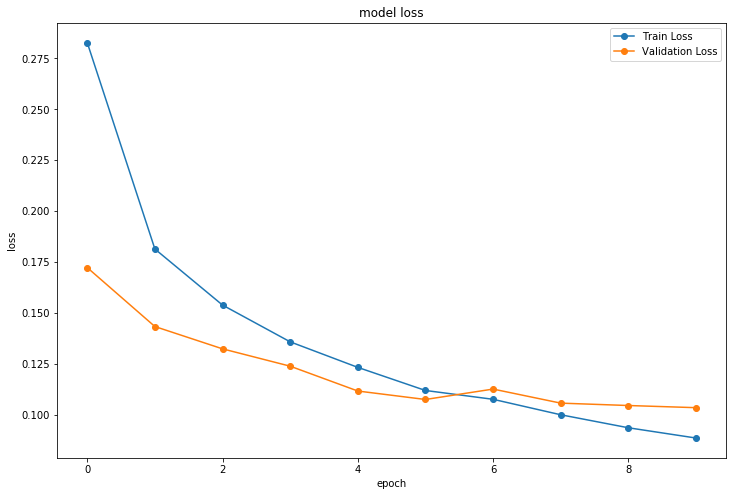

In [36]:
# pyplot inline
import matplotlib.pyplot as plt
# summarize history for loss
f = plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], '-o', label='Train Loss')
plt.plot(history.history['val_loss'], '-o', label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [37]:
from sklearn.metrics import f1_score, precision_score,recall_score
predictions = model.predict(test_docs_pad)>.5

precision = precision_score(test_labels, predictions,
                            average='micro')
recall = recall_score(test_labels, predictions,
                      average='micro')
f1 = f1_score(test_labels, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}"
        .format(precision, recall, f1))
 
precision = precision_score(test_labels, predictions,
                            average='macro')
recall = recall_score(test_labels, predictions,
                      average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}"
        .format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.5460, Recall: 0.7692, F1-measure: 0.6387
Macro-average quality numbers
Precision: 0.1582, Recall: 0.1896, F1-measure: 0.1427


In [38]:
from sklearn.metrics import classification_report
report = classification_report(test_labels, predictions)
print(report)

             precision    recall  f1-score   support

          0       0.82      0.98      0.89       719
          1       0.00      0.00      0.00        23
          2       0.11      0.50      0.19        14
          3       0.32      0.40      0.35        30
          4       0.14      0.22      0.17        18
          5       0.00      0.00      0.00         1
          6       0.00      0.00      0.00        18
          7       0.00      0.00      0.00         2
          8       0.00      0.00      0.00         3
          9       0.57      0.29      0.38        28
         10       0.57      0.22      0.32        18
         11       0.00      0.00      0.00         1
         12       0.20      0.91      0.33        56
         13       0.00      0.00      0.00        20
         14       0.00      0.00      0.00         2
         15       0.38      0.32      0.35        28
         16       0.00      0.00      0.00         1
         17       0.56      0.87      0.68   

/media/Data/Ian/miniconda/envs/tf2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SVM classifier

train SVM on tf idf vectors

In [39]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# inputs
x_train = tfidf_train_docs
x_test = tfidf_test_docs

# Classifier
classifier = OneVsRestClassifier(LinearSVC(random_state=42))
classifier.fit(x_train, train_labels)
 
predictions = classifier.predict(x_test)

In [40]:
from sklearn.metrics import f1_score, precision_score,recall_score
 
precision = precision_score(test_labels, predictions,
                            average='micro')
recall = recall_score(test_labels, predictions,
                      average='micro')
f1 = f1_score(test_labels, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}"
        .format(precision, recall, f1))
 
precision = precision_score(test_labels, predictions,
                            average='macro')
recall = recall_score(test_labels, predictions,
                      average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}"
        .format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.9441, Recall: 0.7978, F1-measure: 0.8648
Macro-average quality numbers
Precision: 0.6088, Recall: 0.3622, F1-measure: 0.4314


trian SVM on word embeddings

In [41]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# inputs
x_train = embedded_train_docs
x_test = embedded_test_docs

# Classifier
classifier = OneVsRestClassifier(LinearSVC(random_state=42))
classifier.fit(x_train, train_labels)
 
predictions = classifier.predict(x_test)

In [42]:
from sklearn.metrics import f1_score, precision_score,recall_score
 
precision = precision_score(test_labels, predictions,
                            average='micro')
recall = recall_score(test_labels, predictions,
                      average='micro')
f1 = f1_score(test_labels, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}"
        .format(precision, recall, f1))
 
precision = precision_score(test_labels, predictions,
                            average='macro')
recall = recall_score(test_labels, predictions,
                      average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}"
        .format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.9428, Recall: 0.5812, F1-measure: 0.7191
Macro-average quality numbers
Precision: 0.2688, Recall: 0.0798, F1-measure: 0.1072


In [ ]:
report = classification_report(test_labels, predictions)
print(report)